In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC

In [18]:
# Load the dataset
df = pd.read_csv('df_ape_preprocessed_2.csv')

In [ ]:
df.head()

In [19]:
columns_to_drop = [
    'metadata', 'file_url', 'creator_address', 'updated_date', 
    'attributes', 'strategy', 'collection_size', 'updated_date.1', 'metadata_Earring'
    ,'token_id',	'last_sale_price' , 'rank'
]
df=df.drop(columns_to_drop, axis=1)
df = df.dropna()

In [20]:
ape_X = df.drop('score', axis=1)
ape_y = df['score']

In [21]:
# 3. Split the dataset into training (60%), validation (20%), and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(ape_X, ape_y, test_size=0.2, random_state=0)


print(X_train[:5], '\n\n', y_train[:5])

     metadata_Background  metadata_Fur metadata_Clothes   metadata_Mouth  \
1413          Aquamarine         Cream    Black Holes T  Bored Bubblegum   
1047          Aquamarine           Tan       Puffy Vest            Bored   
1781          Army Green           Tan  Wool Turtleneck            Bored   
222           Army Green  Golden Brown     Sailor Shirt      Dumbfounded   
1768          Aquamarine       Cheetah       Tweed Suit             Grin   

     metadata_Eyes  metadata_Hat  
1413        X Eyes  Short Mohawk  
1047        Sleepy          Halo  
1781            3d        Safari  
222         Cyborg    Commie Hat  
1768        Zombie    Irish Boho   

 1413    1.100509
1047    0.884313
1781    0.934584
222     1.204682
1768    1.056140
Name: score, dtype: float64


In [22]:
columns_to_encode = [
    'metadata_Background', 'metadata_Fur', 'metadata_Clothes', 
    'metadata_Mouth', 'metadata_Eyes', 'metadata_Hat'
]

# Perform one-hot encoding on the specified columns
encoded_X_train = pd.get_dummies(X_train, columns=columns_to_encode)
encoded_X_test = pd.get_dummies(X_test, columns=columns_to_encode)
# Find the columns in X_train_encoded that are not in X_test_encoded
unmatched_columns = [col for col in encoded_X_train.columns if col not in encoded_X_test.columns]

# Drop the unmatched columns from X_train_encoded
encoded_X_train = encoded_X_train.drop(unmatched_columns, axis=1)


In [23]:
# drop low variance columns, setting threshold = 0.02. 

from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.02)
var_thr.fit(encoded_X_train)

# pick low variance columns
concol_train = [column for column in encoded_X_train.columns if column not in encoded_X_train.columns[var_thr.get_support()]]

# drop low variance columns
X_train_variance = encoded_X_train.drop(concol_train,axis=1)
X_train_variance

# print dropped columns
print(concol_train)
print(len(concol_train))

['metadata_Fur_Noise', 'metadata_Fur_Trippy', 'metadata_Clothes_Bandolier', 'metadata_Clothes_Biker Vest', 'metadata_Clothes_Black Holes T', 'metadata_Clothes_Black Suit', 'metadata_Clothes_Blue Dress', 'metadata_Clothes_Guayabera', 'metadata_Clothes_Hip Hop', 'metadata_Clothes_Kings Robe', 'metadata_Clothes_Lab Coat', 'metadata_Clothes_Pimp Coat', 'metadata_Clothes_Prom Dress', 'metadata_Clothes_Rainbow Suspenders', 'metadata_Clothes_Sleeveless Logo T', 'metadata_Clothes_Space Suit', 'metadata_Clothes_Stunt Jacket', 'metadata_Clothes_Tie Dye', 'metadata_Clothes_Tweed Suit', 'metadata_Clothes_Work Vest', 'metadata_Mouth_Bored Bubblegum', 'metadata_Mouth_Bored Party Horn', 'metadata_Mouth_Bored Pipe', 'metadata_Mouth_Bored Pizza', 'metadata_Mouth_Bored Unshaven Cigar', 'metadata_Mouth_Bored Unshaven Pipe', 'metadata_Mouth_Bored Unshaven Pizza', 'metadata_Mouth_Grin Diamond Grill', 'metadata_Mouth_Grin Multicolored', 'metadata_Mouth_Phoneme Oh', 'metadata_Mouth_Phoneme Wah', 'metadata_Mo

In [24]:
# drop low variance columns

concol_test = [column for column in encoded_X_test.columns if column not in X_train_variance.columns]
X_test_variance = encoded_X_test.drop(concol_test,axis=1)
X_test_variance

# print dropped columns
print(concol_test)

['metadata_Fur_Noise', 'metadata_Fur_Trippy', 'metadata_Clothes_Bandolier', 'metadata_Clothes_Biker Vest', 'metadata_Clothes_Black Holes T', 'metadata_Clothes_Black Suit', 'metadata_Clothes_Blue Dress', 'metadata_Clothes_Guayabera', 'metadata_Clothes_Hip Hop', 'metadata_Clothes_Kings Robe', 'metadata_Clothes_Lab Coat', 'metadata_Clothes_Pimp Coat', 'metadata_Clothes_Prom Dress', 'metadata_Clothes_Rainbow Suspenders', 'metadata_Clothes_Sleeveless Logo T', 'metadata_Clothes_Space Suit', 'metadata_Clothes_Stunt Jacket', 'metadata_Clothes_Tie Dye', 'metadata_Clothes_Tweed Suit', 'metadata_Clothes_Work Vest', 'metadata_Mouth_Bored Bubblegum', 'metadata_Mouth_Bored Party Horn', 'metadata_Mouth_Bored Pipe', 'metadata_Mouth_Bored Pizza', 'metadata_Mouth_Bored Unshaven Cigar', 'metadata_Mouth_Bored Unshaven Pipe', 'metadata_Mouth_Bored Unshaven Pizza', 'metadata_Mouth_Grin Diamond Grill', 'metadata_Mouth_Grin Multicolored', 'metadata_Mouth_Phoneme Oh', 'metadata_Mouth_Phoneme Wah', 'metadata_Mo

In [ ]:
corr_matrix=X_train_variance.corr()
corr_matrix.mask(corr_matrix.abs() < 0.9)
plt.figure(figsize=(50, 50),dpi=144)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [32]:
# n_components=40 as for now and can be changed
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X_train_reduced = pca.fit_transform(X_train_variance)
X_train_reduced = pd.DataFrame(X_train_reduced)
explained_variance_train = pca.explained_variance_ratio_.sum()
print(explained_variance_train)

0.8427599467164174


In [33]:
X_test_reduced = pca.transform(X_test_variance)
X_test_reduced = pd.DataFrame(X_test_reduced)
explained_variance_test = pca.explained_variance_ratio_.sum()
print(explained_variance_test)

0.8427599467164174


In [47]:
#X_train_reduced, X_test_reduced, y_train, y_test
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Create and train the XGBoost regressor
regressor = xgb.XGBRegressor(objective='reg:squarederror')
regressor.fit(X_train_reduced, y_train)

# Make predictions using the trained model
y_pred = regressor.predict(X_test_reduced)
pred_train_xgb = regressor.predict(X_train_reduced)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
# Calculate the mean squared error
mse = mean_squared_error(y_train, pred_train_xgb)
print(f"Mean Squared Error: {mse}")
# Calculate the R-squared score
r2 = r2_score(y_train, pred_train_xgb)
print(f"R-squared: {r2}")

Mean Squared Error: 0.009772050911338643
R-squared: 0.08561167908088474
Mean Squared Error: 9.359404311804033e-07
R-squared: 0.9999337402885355


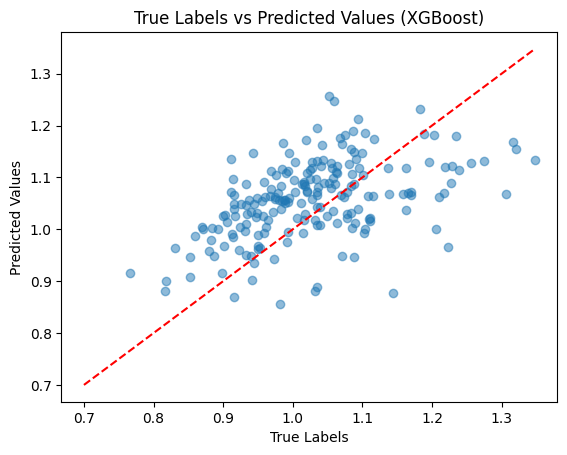

In [41]:
import matplotlib.pyplot as plt

# Create a scatter plot comparing the true labels and the predicted values from XGBoost
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('True Labels vs Predicted Values (XGBoost)')

# Add a diagonal line representing a perfect prediction
max_value = max(max(y_test), max(y_pred))
plt.plot([0.7, max_value], [0.7, max_value], color='red', linestyle='--')

# Show the plot
plt.show()

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=500,random_state=42)
rf_regressor.fit(X_train_reduced, y_train)
# Make predictions using the trained model
y_pred_rf = rf_regressor.predict(X_test_reduced)
pred_train_rf = rf_regressor.predict(X_train_reduced)
# Calculate the mean squared error
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")
# Calculate the R-squared score
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R-squared (Random Forest): {r2_rf}")
mse_rf_train = mean_squared_error(y_train, pred_train_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf_train}")
# Calculate the R-squared score
r2_rf_train = r2_score(y_train, pred_train_rf)
print(f"R-squared (Random Forest): {r2_rf_train}")

Mean Squared Error (Random Forest): 0.009280390390927915
R-squared (Random Forest): 0.13161723531462732
Mean Squared Error (Random Forest): 0.001415748734387321
R-squared (Random Forest): 0.8997723578109492


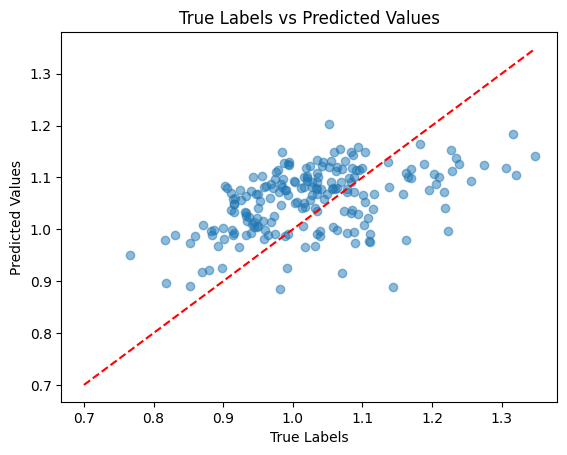

In [48]:
import matplotlib.pyplot as plt

# Create a scatter plot comparing the true labels and the predicted values
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('True Labels vs Predicted Values')

# Add a diagonal line representing a perfect prediction
max_value = max(max(y_test), max(y_pred_rf))
plt.plot([0.7, max_value], [0.7, max_value], color='red', linestyle='--')

# Show the plot
plt.show()

In [43]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_reduced, y_train)
y_pred_lr = lr_model.predict(X_test_reduced)
pred_train = lr_model.predict(X_train_reduced)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Mean Squared Error (Linear Regression): {mse_lr}")


r2_lr = r2_score(y_test, y_pred_lr)
print(f"R-squared (Linear Regression): {r2_lr}")
from sklearn.metrics import mean_squared_error, r2_score
mse_lr_train = mean_squared_error(y_train, pred_train)
print(f"Mean Squared Error on Training Set (Linear Regression): {mse_lr_train}")
r2_lr_train = r2_score(y_train, pred_train)
print(f"R-squared on Training Set (Linear Regression): {r2_lr_train}")


Mean Squared Error (Linear Regression): 0.008951780387269168
R-squared (Linear Regression): 0.16236586241542328
Mean Squared Error on Training Set (Linear Regression): 0.008621136843353203
R-squared on Training Set (Linear Regression): 0.38966837983974245


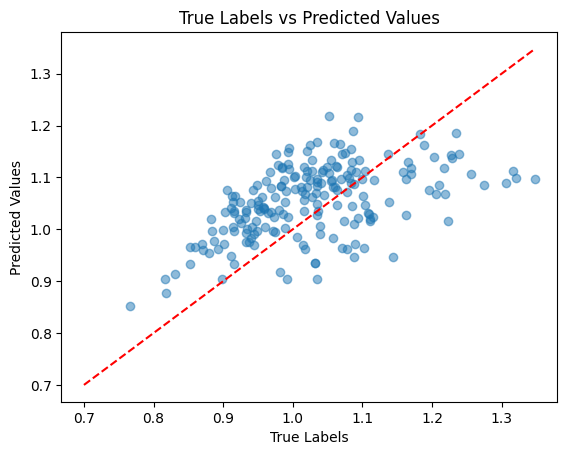

In [44]:
import matplotlib.pyplot as plt

# Create a scatter plot comparing the true labels and the predicted values
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('True Labels vs Predicted Values')

# Add a diagonal line representing a perfect prediction
max_value = max(max(y_test), max(y_pred_lr))
plt.plot([0.7, max_value], [0.7, max_value], color='red', linestyle='--')

# Show the plot
plt.show()